- original: https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/a60617788061539b5449701ae76aee56/seq2seq_translation_tutorial.ipynb#scrollTo=9j9xzK9gFgNL
- url: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- related: file:///Users/asakawa/study/2021personal/2018Eitenne_seq2seq_ja.md
- filename: 2022_0115seq2seq_translation_tutorial.ipynb



In [ ]:
%matplotlib inline


<!-- NLP From Scratch: Translation with a Sequence to Sequence Network and Attention -->
# ゼロからの自然言語処理 (NLP): Seq2seq (あるいは，エンコーダ・デコーダ) ネットワークによる翻訳と注意
*******************************************************************************
**Author**: [Sean Robertson](https://github.com/spro/practical-pytorch)

このチュートリアルは 「ゼロからの自然言語処理 (NLP)」を行うための 3 つ目のチュートリアルで，最後になります。
このチュートリアルを終えた後は，このチュートリアルに続く 3 つのチュートリアルで，`torchtext` がどのようにこの前処理の多くを処理できるかを学んでください。

<!-- This is the third and final tutorial on doing "NLP From Scratch", where we write our own classes and functions to preprocess the data to do our NLP modeling tasks. 
We hope after you complete this tutorial that you'll proceed to learn how `torchtext` can handle much of this preprocessing for you in the three tutorials immediately following this one.-->

このプロジェクトでは，ニューラルネットワークにフランス語から英語への翻訳を教えます。
<!-- In this project we will be teaching a neural network to translate from French to English. -->


    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... と、程度の差こそあれ、成功しています。
<!-- to varying degrees of success. -->

これを可能にしているのが，2 つのリカレントニューラルネットワークが協力して，ある系列を別の系列に変換するという，シンプルだが強力な [sequence to sequence network](https://arxiv.org/abs/1409.3215) というアイデアです。
符号化ネットワークは，入力系列をベクトルに凝縮し，復号化ネットワークは，そのベクトルを新しい系列に展開します。
<!-- This is made possible by the simple but powerful idea of the `sequence to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two recurrent neural networks work together to transform one sequence to another. 
An encoder network condenses an input sequence into a vector, and a decoder network unfolds that vector into a new sequence. -->

<center>
<img src="https://pytorch.org/tutorials/_images/seq2seq.png">
</center>

このモデルを改良するために，復号化器(デコーダ) に入力配列の特定の範囲に集中することを学習させる [注意機構](https://arxiv.org/abs/1409.0473) を使用します。
<!-- To improve upon this model we'll use an `attention mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder learn to focus over a specific range of the input sequence. -->

**オススメの読み物**

PyTorch がインストール済で，Python を知っていて，テンソル (Tensors) を理解していることが前提です。

- PyTorhch のインストールについては [https://pytorch.org](https://pytorch.org)
-  PyTorchの一般的な使用方法については [60 分でわかるディープラーニング](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
- 広く深く概要を知るためには，[具体例でわかる Pytorch](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
- 旧 Lua Torch ユーザの場合は  [former_torchies_tutorial](https://pytorch.org/tutorials/beginner/former_torchies_tutorial.html) となります

<!-- **Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user -->

また Sequence to Sequence ネットワークとその仕組みについても知っておくと役に立つでしょう。

- [Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation](https://arxiv.org/abs/1406.1078)
- [Sequence to Sequence Learning with Neural Networks（ニューラルネットワークによる系列から系列間の学習）](https://arxiv.org/abs/1409.3215)
- [整列と翻訳を同時に学習するニューラル機械翻訳](https://arxiv.org/abs/1409.0473)
- [ニューラル対話モデル](https://arxiv.org/abs/1506.05869)

また，l以前のチュートリアルである [文字ベース RNN チュートリアル](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) と[中級：文字生成チュートリアル](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)  は，それぞれの概念が符号化モデルと復号化モデルに非常に似ているので，参考になるでしょう。

<!-- 
It would also be useful to know about Sequence to Sequence networks and how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`
-  `Sequence to Sequence Learning with Neural Networks <https://arxiv.org/abs/1409.3215>`
-  `Neural Machine Translation by Jointly Learning to Align and Translate <https://arxiv.org/abs/1409.0473>`
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`

You will also find the previous tutorials on :doc:`/intermediate/char_rnn_classification_tutorial` and :doc:`/intermediate/char_rnn_generation_tutorial` helpful as those concepts are very similar to the Encoder and Decoder models, respectively.

**必要条件**.
<!--**Requirements** -->



In [51]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. データファイルの読み込み
<!-- Loading data files-->

このプロジェクトのデータは、何千もの英仏の翻訳対のセットです。
<!-- The data for this project is a set of many thousands of English to French translation pairs. -->

[Open Data Stack Exchange](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)  のこの質問は、 https://tatoeba.org/ というオープンな翻訳サイトを教えてくれました。
さらに，言語対を個々のテキストファイルに分割するという余分な作業をしてくれた人がいます： https://www.manythings.org/anki/ 
英語とフランス語のペアは大きすぎてレポに含めることができないので，続ける前に  ``data/eng-fra.txt`` にダウンロードしてください。
このファイルは翻訳対のタブ区切りのリストです。
<!--
`This question on Open Data Stack Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>` pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better yet, someone did the extra work of splitting language pairs into individual text files here: https://www.manythings.org/anki/ 
The English to French pairs are too big to include in the repo, so download to ``data/eng-fra.txt`` before continuing. 
The file is a tab separated list of translation pairs: -->


    I am cold.    J'ai froid.

### 注::

データは [こちら](https://download.pytorch.org/tutorial/data.zip) からダウンロードし，カレントディレクトリに展開してください。
<!-- Download the data from [here](https://download.pytorch.org/tutorial/data.zip) and extract it to the current directory. -->

In [52]:
# 訳注: ダウンロードするには，このセルの下の 2 行の行頭の # をコメントアウトして，実行してください
#!wget -O data.zip https://download.pytorch.org/tutorial/data.zip
#!unzip data.zip

文字レベルの RNN チュートリアルで使用した文字符号化と同様，ここでは，言語の各単語をワンホットベクトル，つまり 1 つの 1 (単語のインデックス) を除くゼロの巨大なベクトルとして表現します。
1 つの言語に存在する数十個の文字に比べて，単語の数ははるかに多いので，符号化ベクトルははるかに大きくなります。
しかし，ここでは少しズルをして 1 つの言語につき数千語しか使わないようにデータを切り詰めます。
<!-- Similar to the character encoding used in the character-level RNN tutorials, we will be representing each word in a language as a one-hot vector, or giant vector of zeros except for a single one (at the index of the word). Compared to the dozens of characters that might exist in a language, there are many many more words, so the encoding vector is much larger. 
We will however cheat a bit and trim the data to only use a few thousand words per language. -->

<center>
<img src="https://pytorch.org/tutorials/_images/word-encoding.png">
</center>
<!-- 
.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt: -->





後でネットワークの入力とターゲットとして使うために、単語ごとにユニークなインデックスが必要になります。
``Lang`` というヘルパークラスを使って，単語→索引 (``word2index``) と索引→単語 (``index2word``) の辞書を持ち，さらに各単語の数をカウントする ``word2count`` も持っています。
このクラスは，単語を ID に変換 (word → index ``word2index``) と ID を単語に変換 ( index → word ``index2word``)  の辞書と，各単語の頻度 ``word2count``  を持っており，これは後で低頻度語を置き換えるために使用されます。

<!-- We'll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called ``Lang`` which has word → index (``word2index``) and index → word (``index2word``) dictionaries, as well as a count of each word ``word2count`` which will be used to replace rare words later. -->


In [53]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

ファイルはすべて Unicode で，簡略化するために，Unicode の文字を ASCII に変換し，すべて小文字にして，ほとんどの句読点を削除します。
<!-- The files are all in Unicode, to simplify we will turn Unicode characters to ASCII, make everything lowercase, and trim most punctuation. -->


In [54]:
# Unicode の文字列を ASCII に変換 # Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 小文字化、トリミング、非文字の削除 # Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

データファイルを読むために，ファイルを行に分割し，さらに行を対に分割します。
ファイルはすべて英語→その他の言語なので，その他の言語→英語に翻訳したい場合は、``reverse`` フラグを追加して、対を逆にしています。
<!-- To read the data file we will split the file into lines, and then split lines into pairs. 
The files are all English → Other Language, so if we want to translate from Other Language → English I added the ``reverse`` flag to reverse the pairs.
-->


In [55]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [56]:
#readLangs('eng', 'fra')

たくさんの例文があり，すぐに訓練を行いたいので，データセットを比較的短くて単純な文だけに絞り込みます。
ここでは，最大の文長は 10 語 (最後の句読点を含む) とし，I am や He is などの形に変換される文にフィルタリングします (以前に置き換えられたアポストロフィを考慮して)。
<!-- Since there are a *lot* of example sentences and we want to train something quickly, we'll trim the data set to only relatively short and simple sentences. 
Here the maximum length is 10 words (that includes ending punctuation) and we're filtering to sentences that translate to the form "I am" or "He is" etc. (accounting for apostrophes replaced earlier).
-->


In [57]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

データ作成の全工程は
<!-- The full process for preparing the data is: -->

- テキストファイルを読み込んで行単位に分割，行をペアに分割
- テキストを正規化し、長さと内容でフィルタリング
- 文章をペアにして単語リストを作成

<!--
-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs
-->


In [58]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['il est a l eglise en ce moment .', 'he s at church right now .']


In [59]:
pairs[:3]

[['j ai ans .', 'i m .'],
 ['je vais bien .', 'i m ok .'],
 ['ca va .', 'i m ok .']]

# 2. Seq2Seqモデル
<!-- The Seq2Seq Model 
================= -->

Recurrent Neural Network (RNN) は，系列を操作し，自分の出力を後続のステップの入力として使用するネットワークです。
<!-- A Recurrent Neural Network, or RNN, is a network that operates on a sequence and uses its own output as input for subsequent steps. -->

[Sequence to Sequence network](https://arxiv.org/abs/1409.3215),  すなわち  seq2seq ネットワーク，または，[エンコーダ・デコーダネットワーク](https://arxiv.org/pdf/1406.1078v3.pdf)  は，符号化器と復号化器と呼ばれる 2 つの RNN からなるモデルです。
符号化器は入力配列を読み込んで 1 つのベクトルを出力し，復号化器はそのベクトルを読み込んで出力配列を生成します。
<!-- A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or seq2seq network, or `Encoder Decoder network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence. -->

<center>
<img src="https://pytorch.org/tutorials/_images/seq2seq.png">
</center>
<!-- 
.. figure:: /_static/img/seq-seq-images/seq2seq.png
 :alt: -->
 
すべての入力が出力に対応する単一の RNN による配列予測とは異なり，seq2seq モデルでは，配列の長さや順序から解放されるため，2 つの言語間の翻訳に最適です。
<!-- Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages. -->

Je ne suis pas le chat noir →「私は黒猫ではない，という文を考えてみましょう。
入力文のほとんどの単語は出力文で直訳されていますが，例えば chat noir と black cat のように，順序が少しずつ異なっています。
また、 ne/pas 構文のため，入力文にはもう一つの単語があります。
このように，入力された単語の並びから直接正しい翻訳を行うことは困難です。
<!-- Consider the sentence "Je ne suis pas le chat noir" → "I am not the black cat". Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. "chat noir" and "black cat". Because of the "ne/pas" construction there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words. -->

seq2seq モデルでは，符号化器 は 1 つのベクトルを作成し，理想的なケースでは，入力系列の「意味」を 1 つのベクトル，つまり文の N 次元空間の 1 つの点に符号化します。
<!-- With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the "meaning" of the input sequence into a single vector — a single point in some N dimensional space of sentences. -->




## 2.1 符号化器 (エンコーダ)
<!-- The Encoder
---------- -->

seq2seq ネットワークの符号化器 (エンコーダ) は，入力文の各単語に対して何らかの値を出力する RNN です。
符号化器 (エンコーダ) は，入力された単語ごとに，ベクトルと隠れ層状態を出力し，隠れ層の状態を次の時刻の入力単語に使用します。
<!-- The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word. -->

<center>
<img src="https://pytorch.org/tutorials/_images/encoder-network.png">
</center>
<!-- 
.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt: -->





In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 2.2 複合化器 (デコーダ)
<!-- The Decoder 
----------- -->

複合化器 (デコーダ) は，符号化器の出力ベクトルを受け取り，翻訳を作成するための一連の単語を出力する別の RNN です。
<!--
The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation. -->



## 2.3 簡単な符号化器
<!-- ### Simple Decoder -->

最も単純な seq2seq 符号化器では，符号化器の最後の出力のみを使用します。
この最後の出力は，系列全体の文脈を符号化しているので，**文脈ベクトル** と呼ばれることもあります。
この文脈ベクトルは，複合化器の初期隠れ状態として使われます。
<!--
In the simplest seq2seq decoder we use only last output of the encoder. 
This last output is sometimes called the *context vector* as it encodes context from the entire sequence. 
This context vector is used as the initial hidden state of the decoder. -->

複合化の各段階で，複合化器には入力トークンと隠れ状態が与えられます。
最初の入力トークンは，文字列の先頭の ``<SOS>`` トークンで，最初の隠れた状態は，文脈ベクトル (符号化器の最後の隠れ層状態) です。
<!-- 
At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string ``<SOS>`` token, and the first hidden state is the context vector (the encoder's last hidden state). -->


<center>
<img src="https://pytorch.org/tutorials/_images/decoder-network.png">
</center>
<!-- .. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt: -->





In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

このモデルを使って訓練を行い，その結果を観察することをお勧めしますが，スペースを節約するために，今回はストレートに「注意機構」を紹介します。
<!-- I encourage you to train and observe the results of this model, but to save space we'll be going straight for the gold and introducing the Attention Mechanism. -->




## 2.4 注意つき符号化器
<!-- Attention Decoder
^^^^^^^^^^^^^^^^^ -->

符号化器と複合化器との間で文脈ベクトルだけが渡されると，その 1 つのベクトルが文全体の符号化を担うことになりまする。
<!-- If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence. -->

注意は，復号化ネットワークが，複合化器自身の出力の各ステップごとに，符号化器の出力の異なる部分に「焦点を合せる」することを可能にします。
まず，一連の *注意重み* を計算します。
この重みを符号化器の出力ベクトルに掛け合わせて，重み付きの組み合わせを作ります。
この結果 (コードでは ``attn_applied`` と呼ばれています) には，入力系列の特定の部分に関する情報が含まれており，複合化器が正しい出力語を選択するのに役立つはずです。
<!-- Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs. 
First we calculate a set of *attention weights*. These will be multiplied by the encoder output vectors to create a weighted combination. 
The result (called ``attn_applied`` in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words. -->

<center>
<img src="https://i.imgur.com/1152PYf.png">
</center>
<!-- 
.. figure:: https://i.imgur.com/1152PYf.png
   :alt: -->

注意の重みの計算は，復号化器の入力と隠れ状態を入力として，別のフィードフォワード層 ``attn`` で行います。
学習データにはあらゆるサイズの文が含まれているので，この層を実際に作成して学習するには，この層が適用できる最大の文の長さ (符号化器の出力に対する入力の長さ) を選択する必要があります。
最大の長さの文では，すべての注意重みを使用しますが，短い文では最初のいくつかの重みしか使用しません。
<!-- Calculating the attention weights is done with another feed-forward layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few. -->

<center>
<img src="https://pytorch.org/tutorials/_images/attention-decoder-network.png"
</center>
<!-- 
.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt: -->





In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info">
<h4>注</h4><p>

長さの制限を回避するために，相対的な位置関係を利用した注意の形態もあります。
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)  では 局所的注意について書かれています。
<!-- There are other forms of attention that work around the length limitation by using a relative position approach. 
Read about "local attention" in `Effective Approaches to Attention-based Neural Machine Translation <https://arxiv.org/abs/1508.04025>`. -->
</p></div>

# 3. 訓練

<!-- Training
======== -->

## 3.1 訓練データの準備
-----------------------
<!-- Preparing Training Data
----------------------- -->

学習のためには，各対に対して，入力テンソル (入力文中の単語のインデックス) とターゲットテンソル (ターゲット文中の単語のインデックス) が必要になります。
これらのベクトルを作成する際に，EOS トークン を両方の系列に追加します。
<!--
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). 
While creating these vectors we will append the EOS token to both sequences.-->


In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 3.2 モデルの訓練
<!-- Training the Model
------------------ -->

学習のために，入力文を符号化器に通し，すべての出力と最新の隠れ状態を記録します。
そして，復号化器には，最初の入力として ``<SOS>`` トークンが与えられ，最初の隠れ状態として符号化器の最後の隠れ状態が与えられます。
<!-- To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. 
Then the decoder is given the ``<SOS>`` token as its first input, and the last hidden state of the encoder as its first hidden state. -->

**教師強制 Teacher forcing**  とは，復号化器の推測を次の入力として使うのではなく，実際の目標出力をそれぞれの次の入力として使うという概念です。
教師強制を使うと，収束が早くなりますが，[学習したネットワークを利用すると、不安定になることがあります] (http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf) 。
<!-- "Teacher forcing" is the concept of using the real target outputs as each next input, instead of using the decoder's guess as the next input. 
Using teacher forcing causes it to converge faster but `when the trained network is exploited, it may exhibit instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__. -->

直感的には，出力された文法を表現することを学習し，教師が最初の数語を教えれば意味を「拾う」ことができますが，そもそも翻訳から文を作る方法を適切に学習していないのです。
<!-- You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can "pick up" the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation  in the first place. -->

PyTorch の autograd は自由度が高いので，単純な if 文で教師の強制を使うかどうかをランダムに選ぶことができます。
``Teacher_forcing_ratio`` を上げれば、より多くの強制力を使うことができます。
<!-- Because of the freedom PyTorch's autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. 
Turn ``teacher_forcing_ratio`` up to use more of it. -->


In [ ]:
teacher_forcing_ratio = 0.5  # 訳注：教師強制率。文献によっては，訓練中にこの値を徐々に減衰させることも行われます

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

以下は，現在の時刻と進行状況から，経過時間と残り時間の推定値を表示するヘルパー関数です。
<!-- This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.-->


In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

訓練の全体像は以下のようになっています。
<!-- The whole training process looks like this:-->

- タイマーの起動
- 最適化関数と収束基準の初期化
- 訓練対の作成
- プロット用の空の損失配列を作成

<!-- -  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting -->

そして  ``train`` を何度も呼び出し，時々，進捗状況 (例の割合，これまでの時間，推定時間) と平均損失を表示します。
<!--
Then we call ``train`` many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.
-->

In [ ]:
# 訳注：一般には，`fit()` あるいは `train()` などと命名される関数，訓練を n_iters だけ繰り返す
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## 3.3 結果のプロット
<!-- Plotting results
------------------>

プロットには matplotlib を使用し，訓練中に保存された損失値の配列  ``plot_losses``  を使用します。
<!--
Plotting is done with matplotlib, using the array of loss values ``plot_losses`` saved while training.
-->

In [ ]:
import matplotlib.pyplot as plt
#backend が 'agg' だと動作しない場合があるのでコメントアウト
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
#help(plt.switch_backend)

# 4. 評価
<!-- Evaluation
========== -->

評価は訓練とほぼ同じですが，ターゲットがないので，各ステップで復号化器の予測値を自分自身にフィードバックするだけです。
単語を予測するたびに，その単語を出力文字列に追加し，EOS トークンを予測した場合はそこで止めます。
また，復号化器の注意の出力を保存し，後で表示できるようにしています。
<!--
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. 
We also store the decoder's attention outputs for display later.
-->

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

訓練セットからランダムな文章を評価し，入力，ターゲット，出力をプリントアウトすることで，主観的な品質判断を行うことができます。
<!-- We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:
-->

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

# 5. 訓練と評価
<!-- Training and Evaluating
=======================  -->

これらのヘルパー関数が揃ったところで (余計なことをしているように見えますが，複数の実験を簡単に行うことができます)，実際にネットワークを初期化して訓練を開始します。
<!-- With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training. -->

入力文は大きくフィルタリングされていることを覚えておいてください。
この小さなデータセットでは，256 の隠れノードと 1 つの GRU 層 という，比較的小さなネットワークを使うことができます。
MacBook の CPU で約 40 分後，妥当な結果が得られます。
<!-- Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. 
After about 40 minutes on a MacBook CPU we'll get some reasonable results. -->

注：
   このノートブックを実行すると，訓練を行い，カーネルを中断し，評価を行い，後で訓練を続けることができます。
符号化器と復号化器を初期化している行をコメントアウトして，再度  ``trainIters`` を実行してください．
<!--
.. Note::
   If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. Comment out the lines where the encoder and decoder are initialized and run ``trainIters`` again.
-->

In [ ]:
%%time
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#訳注: フランス語に詳しくないので，訓練を繰り返しても正しいかどうか分かりません。
#そこで，時間節約のため，オリジナルの設定の 1/20 だけ実施してみます。
trainIters(encoder1, attn_decoder1, 3250, print_every=250)
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
%%time
trainIters(encoder1, attn_decoder1, 7000, print_every=500)

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

# 6. 注意の可視化
<!-- Visualizing Attention
--------------------- -->

注意機構の有用な特性は，その高度に解釈可能な出力です。
これは，入力系列の特定の復号化器出力に重み付けをするために使用されるので，各時間ステップでネットワークがどこに最も焦点を当てているかを見ることを想像することができます。
<!-- A useful property of the attention mechanism is its highly interpretable outputs. 
Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step. -->

単純に ``plt.matshow(attentions)`` を実行すれば，列が入力ステップ、行が出力ステップの行列として表示された注意出力を見ることができます。
<!-- You could simply run ``plt.matshow(attentions)`` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:
-->

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

より良い表示のために、軸とラベルを追加するという余分な作業を行います。
<!-- For a better viewing experience we will do the extra work of adding axes and labels:
 -->



In [ ]:
import importlib

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

import matplotlib
#matplotlib.use('agg')
matplotlib = importlib.reload(matplotlib)
#matplotlib.use('MacOSX')    
#matplotlib.use('TKAgg',force=True)
##import matplotlib.ticker as ticker

evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# 7. 演習
<!-- Exercises
========= -->

- 別のデータセットで試す
<!-- -  Try with a different dataset -->

- 別の言語対
<!-- -  Another language pair -->
   - 人間 → 機械 (例: IOTコマンド)
   - チャット → 応答
   - 質問 → 回答

<!--
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer
-->

- 埋め込みを word2vec や GloVe などの事前に学習した単語埋め込みに置き換える。
- 層数，隠れユニット数，文の数を増やしてみる。学習時間と結果を比較してみてください。
- 同じフレーズのペアが 2 つある翻訳ファイル（``I am test \t I am test``）を使うと、オートエンコーダーとして使うことができます。
これを試してみてください。

<!-- 
-  Replace the embeddings with pre-trained word embeddings such as word2vec or GloVe
-  Try with more layers, more hidden units, and more sentences. 
Compare the training time and results.
-  If you use a translation file where pairs have two of the same phrase (``I am test \t I am test``), you can use this as an autoencoder. 
Try this:
-->

   - オートエンコーダーとして学習
   - エンコーダーネットワークのみを保存
   - そこから翻訳用のデコーダを新たに学習

<!--    -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there
 -->



---

# A. 浅川の拡張

ここから先は，浅川の拡張です。
フランス語がチンプンカンプンなので，日本語の題材があった方がわかりやすいかと思い，作成してみました。
上のコードと重複して冗長ですが，ここから下だけを切り出しても動作するように，あえて重複させています。

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## A1. データファイルの読み込み

In [22]:
# 訳注: ダウンロードするには，このセルの下の 2 行の行頭の # をコメントアウトして，実行してください
#!wget -O eng-jpn.txt https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/2022notebooks/eng-jpn.txt
#!if ! [ -d data ]; then mkdir data; fi
#!mv eng-jpn.txt data

In [23]:
import platform
isColab = platform.system() == 'Linux'
if isColab:
    !pip install japanize_matplotlib

In [ ]:
SOS_token = 0  # SOS: Start Of Sentence
EOS_token = 1  # EOS: End Of Sentence

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# サンプルコードのように Unicode の文字列を ASCII に変換してしまうと日本語は
# 処理できないので，`unicodeToAscii()` は使わない。
# 小文字化、トリミング、非文字の削除 # Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    #s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'jpn', True)
print(random.choice(pairs))

In [ ]:
print(type(pairs[1]), len(pairs[1]), pairs[1][0])

## A2. Seq2seq モデル

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

### A2.4 注意つき符号化器

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## A3. 訓練

### A3.1 訓練データの準備

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### A3.2 モデルの訓練

In [ ]:
teacher_forcing_ratio = 0.5  # 訳注：教師強制率。文献によっては，訓練中にこの値を徐々に減衰させることも行われます

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    #return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    return f'経過時間:{asMinutes(s)} (残り時間 {asMinutes(rs)})'

In [ ]:
# 訳注：一般には，`fit()` あるいは `train()` などと命名される関数，訓練を n_iters だけ繰り返す
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            #print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
            #                             iter, iter / n_iters * 100, print_loss_avg))
            print(f'{timeSince(start, iter / n_iters)} (反復回数: {iter:5d} 割合:{iter/n_iters:.2f}) 損失: {print_loss_avg:.2f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### A3.3 結果のプロット

In [ ]:
import matplotlib.pyplot as plt
#backend が 'agg' だと動作しない場合があるのでコメントアウト
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## A4. 評価

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## A5. 訓練と評価 

In [ ]:
%%time
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 3250, print_every=250)
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)


In [ ]:
trainIters(encoder1, attn_decoder1, 32500, print_every=2500)
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
#trainIters(encoder1, attn_decoder1, 300, print_every=30)
evaluateRandomly(encoder1, attn_decoder1)

## A6. 注意の可視化

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "怖く なん て ない さ")
plt.matshow(attentions.numpy())

In [ ]:
import importlib
import japanize_matplotlib

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

import matplotlib
#matplotlib.use('agg')
matplotlib = importlib.reload(matplotlib)
#matplotlib.use('MacOSX')    
#matplotlib.use('TKAgg',force=True)
##import matplotlib.ticker as ticker

evaluateAndShowAttention("注意 に 注意 し な さ い 。")
#evaluateAndShowAttention("elle est trop petit .")
#evaluateAndShowAttention("je ne crains pas de mourir .")
#evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# B. 浅川の拡張 その 2

浅川の拡張その 2 です。
日本語から日本語へと変換する。オウム返しの反復になりますが，
これが短期記憶のモデルですし，
符号化器・復号化器モデル (encoder-decoder models) になります。
短期記憶のみならず，情報圧縮，次元削減，注意とも関連します。

上のコード 2 つと重複しています。
ですが，ここから下だけを切り出しても動作するように，あえて重複させています。

## B1. データファイルの読み込み

In [1]:
from __future__ import unicode_literals, print_function, division
# 通信環境にも依存しますが，このセルを Colob 上で実行すると終了までに 15 分くらい待たされることがあります。

%matplotlib inline
import os
import sys
import numpy as np
from termcolor import colored

from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 本ファイルを Google Colaboratory 上で実行する場合に，必要となるライブラリをインストールする
import platform
isColab = platform.system() == 'Linux'
if isColab:
    #!pip install transformers > /dev/null 2>&1 

    # MeCab, fugashi, ipadic のインストール
    !apt install aptitude swig > /dev/null 2>&1
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
    !pip install mecab-python3 > /dev/null 2>&1
    !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 2>&1
    !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null 2>&1
    
    import subprocess
    cmd='echo `mecab-config --dicdir`\"/mecab-ipadic-neologd\"'
    path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                                     shell=True).communicate()[0]).decode('utf-8')

    !pip install 'fugashi[unidic]' > /dev/null 2>&1
    !python -m unidic download > /dev/null 2>&1
    !pip install ipadic > /dev/null 2>&1
    !pip install jaconv > /dev/null 2>&1 
    !pip install japanize_matplotlib > /dev/null 2>&1    

In [2]:
# ダウンロードするには，このセルの下の 2 行の行頭の # をコメントアウトして，実行してください
#!wget -O jpn-eng.zip https://www.manythings.org/anki/jpn-eng.zip    
#!unzip jpn-eng.zip

In [3]:
with open('jpn.txt','r') as fi:
    a = fi.readlines()
a_ = [x.strip().split('\t')[:-1] for x in a]    

In [4]:
import sys
import MeCab
wakati = MeCab.Tagger('-Owakati')
import jaconv

jpn_txt = []
for i, aa in enumerate(a_): # [:3]):
    c1 = jaconv.normalize(a_[i][1])
    a_[i][1] ="".join(wakati.parse(c1).strip())
    jpn_txt.append(a_[i][1])


In [5]:
SOS_token = 0  # SOS: Start Of Sentence
EOS_token = 1  # EOS: End Of Sentence

class Lang:
    """Lang という名前のクラスだが，実体は単語 ID を返す，トークナイザの役割である"""
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [60]:
MAX_LENGTH=10  # 大域変数として MAX_LENGTH を定義したくはないのだが，後の処理で参照されている

input_lang, output_lang = Lang(name='jpn0'), Lang(name='jpn1')

def filtering_lang(lines=jpn_txt,MAX_LENGTH=10):
    src_lang, dst_lang = Lang(name='jpn0'), Lang(name='jpn1')
    pairs = []
    for line in lines:
        length = len(line.split(' '))
        if (3 < length) and (length < MAX_LENGTH):
            src_lang.addSentence(line)
            dst_lang.addSentence(line)
            pairs.append([line,line])

    print("Counted words:")
    print(src_lang.name, src_lang.n_words)
    print(dst_lang.name, dst_lang.n_words)
    return src_lang, dst_lang, pairs

input_lang, output_lang, pairs = filtering_lang(MAX_LENGTH=MAX_LENGTH)
print(random.choice(pairs))
print(type(pairs[1]), len(pairs[1]), pairs[1][0])

Counted words:
jpn0 11050
jpn1 11050
['ごめん 、 起こし ちゃっ た ね 。', 'ごめん 、 起こし ちゃっ た ね 。']
<class 'list'> 2 ジャンプ し て !


## B2 Seq2seq モデル

In [64]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [65]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## B2.4 注意つき符号化器

In [66]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## B3. 訓練

### B3.1 訓練データの準備

In [67]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## B3.2 モデルの訓練

In [68]:
teacher_forcing_ratio = 0.5  # 訳注：教師強制率。文献によっては，訓練中にこの値を徐々に減衰させることも行われます

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [85]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m):2d}分 {int(s):2d}秒'
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    #return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
    return f'経過時間:{asMinutes(s)} (残り時間 {asMinutes(rs)})'

In [86]:
# 訳注：一般には，`fit()` あるいは `train()` などと命名される関数，訓練を n_iters だけ繰り返す
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            #print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
            #                             iter, iter / n_iters * 100, print_loss_avg))
            print(f'{timeSince(start, iter / n_iters)} (反復回数: {iter:5d} 割合:{iter/n_iters:.2f}) 損失: {print_loss_avg:.2f}')

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## B3.3 結果のプロット

In [87]:
import matplotlib.pyplot as plt
#backend が 'agg' だと動作しない場合があるのでコメントアウト
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## B4. 評価

In [88]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [89]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('入力文: ', pair[0])
        print('正解文: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('出力文: ', output_sentence)
        print('')

## B5. 訓練と評価 

In [ ]:
%%time
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

#trainIters(encoder1, attn_decoder1, 3250, print_every=250)
trainIters(encoder1, attn_decoder1, 7500, print_every=1000)
#trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [ ]:
# 訓練が足りなかったら，あるいは，じゅう文に学習した結果を見たければこのセルを実行してください
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

経過時間: 0分  1秒 (残り時間  0分 13秒) (反復回数:    30 割合:0.10) 損失: 2.61
経過時間: 0分  3秒 (残り時間  0分 12秒) (反復回数:    60 割合:0.20) 損失: 2.91
経過時間: 0分  4秒 (残り時間  0分 10秒) (反復回数:    90 割合:0.30) 損失: 3.02
経過時間: 0分  6秒 (残り時間  0分  9秒) (反復回数:   120 割合:0.40) 損失: 3.16
経過時間: 0分  7秒 (残り時間  0分  7秒) (反復回数:   150 割合:0.50) 損失: 3.11
経過時間: 0分  9秒 (残り時間  0分  6秒) (反復回数:   180 割合:0.60) 損失: 2.59
経過時間: 0分 10秒 (残り時間  0分  4秒) (反復回数:   210 割合:0.70) 損失: 2.75
経過時間: 0分 12秒 (残り時間  0分  3秒) (反復回数:   240 割合:0.80) 損失: 2.87
経過時間: 0分 13秒 (残り時間  0分  1秒) (反復回数:   270 割合:0.90) 損失: 2.72
経過時間: 0分 15秒 (残り時間  0分  0秒) (反復回数:   300 割合:1.00) 損失: 3.14
入力文:  お前 なんか 、 もう 必要 ない 。
正解文:  お前 なんか 、 もう 必要 ない 。
出力文:  もう 、 、 、 て ない 。 <EOS>

入力文:  トム の 住所 知っ てる ?
正解文:  トム の 住所 知っ てる ?
出力文:  トム は トム てる てる ? <EOS>

入力文:  トイレ を 借り て も いい です か 。
正解文:  トイレ を 借り て も いい です か 。
出力文:  何 を て て も いい です か 。 <EOS>

入力文:  俺 たち に つい て こい 。
正解文:  俺 たち に つい て こい 。
出力文:  その に に に て て 。 <EOS>

入力文:  あいつ の こと を 頼れ ば いい よ 。
正解文:  あいつ の こと を 頼れ ば いい よ 。
出力文:  君 の を を を な の よ 。 <EOS>

入力

<Figure size 432x288 with 0 Axes>

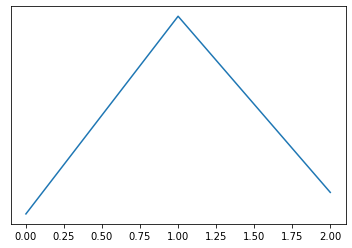

In [90]:
trainIters(encoder1, attn_decoder1, 300, print_every=30)
evaluateRandomly(encoder1, attn_decoder1)

## B6. 注意の可視化

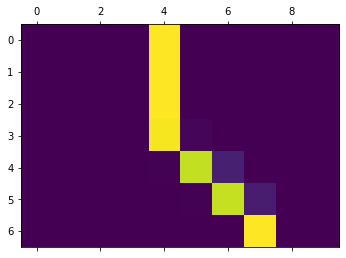

In [91]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "怖く なん て ない さ")
plt.matshow(attentions.numpy())

In [92]:
import importlib
import japanize_matplotlib

input = 注意 に 注意 し な さ い 。
output = 君 に こと な な で ない 。 <EOS>


/var/folders/6g/j7x38zn134n7vlw9jj56rdww0000gn/T/ipykernel_19790/2750690556.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/6g/j7x38zn134n7vlw9jj56rdww0000gn/T/ipykernel_19790/2750690556.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


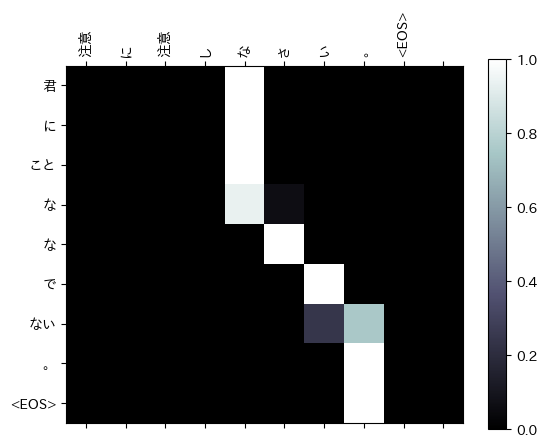

In [93]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

import matplotlib
#matplotlib.use('agg')
matplotlib = importlib.reload(matplotlib)
#matplotlib.use('MacOSX')    
#matplotlib.use('TKAgg',force=True)
##import matplotlib.ticker as ticker

evaluateAndShowAttention("注意 に 注意 し な さ い 。")
#evaluateAndShowAttention("elle est trop petit .")
#evaluateAndShowAttention("je ne crains pas de mourir .")
#evaluateAndShowAttention("c est un jeune directeur plein de talent .")